In [14]:
import os
import time
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import sys 
from pathlib import Path
sys.path.append(os.path.abspath(r"../.."))
from model.generator import Generator, Generator_Transpose
from model.discriminator import DiscriminatorResnet, DiscriminatorLinear, DiscriminatorConv
from utils_.utils import weights_init, weight_init
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## 1. 加载和预处理MNIST数据

In [15]:
from mlxtend.data import loadlocal_mnist
train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
test_data_path = "../../../../data/MNIST/t10k-images.idx3-ubyte"
test_label_path = "../../../../data/MNIST/t10k-labels.idx1-ubyte"

train_data,train_label = loadlocal_mnist(
    images_path = train_data_path,
    labels_path = train_label_path
)
train_data.shape,train_label.shape

((60000, 784), (60000,))

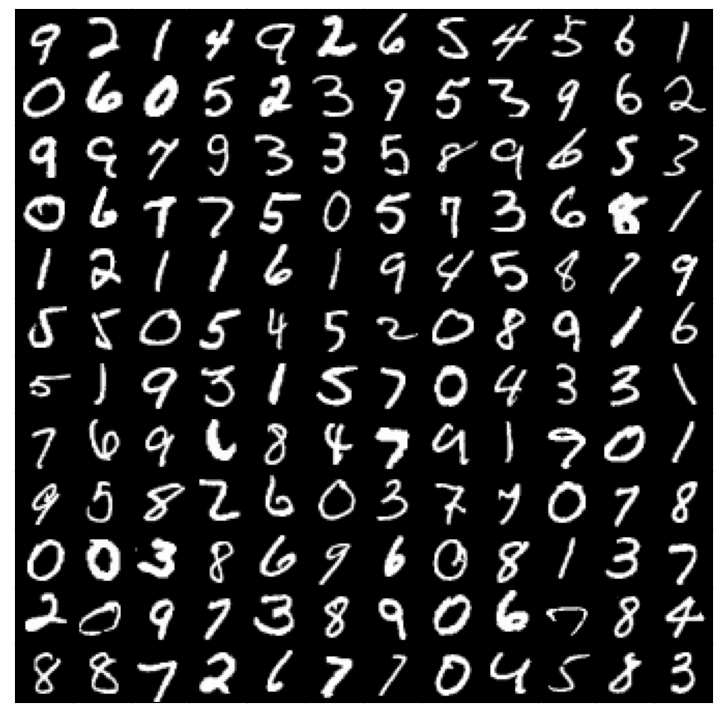

In [26]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(12,12,figsize=(9,9))
plt.subplots_adjust(hspace=0.001,wspace=0.001)
for i in range(12):
    for j in range(12):
        num = np.random.randint(0,train_label.shape[0])
        ax[i][j].imshow(train_data[num].reshape((28,28)),cmap="gray")
        # ax[i][j].set_title(train_label[num],fontdict={"fontsize":20})
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.show()


## 2. Dataset and Model parameter

In [5]:
input_size = [1, 28, 28]
batch_size = 128
Epoch = 1000
GenEpoch = 1
in_channel = 64

In [6]:
from torch.utils.data import Dataset,DataLoader
import numpy as np 
from mlxtend.data import loadlocal_mnist
import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):
    def __init__(self,train_data_path,train_label_path,transform=None):
        train_data,train_label = loadlocal_mnist(
            images_path = train_data_path,
            labels_path = train_label_path
            )
        self.train_data = train_data
        self.train_label = train_label.reshape(-1)
        self.transform=transform
        
    def __len__(self):
        return self.train_label.shape[0] 
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
        images = self.train_data[index,:].reshape((28,28))
        labels = self.train_label[index]
        if self.transform:
            images = self.transform(images)
        return images,labels

train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
transform_dataset =transforms.Compose([
    transforms.ToTensor()]
)
MNIST_dataset = MNIST_Dataset(train_data_path=train_data_path,
                               train_label_path=train_label_path,
                               transform=transform_dataset)  
MNIST_dataloader = DataLoader(dataset=MNIST_dataset,
                              batch_size=batch_size,
                              shuffle=True,drop_last=False)

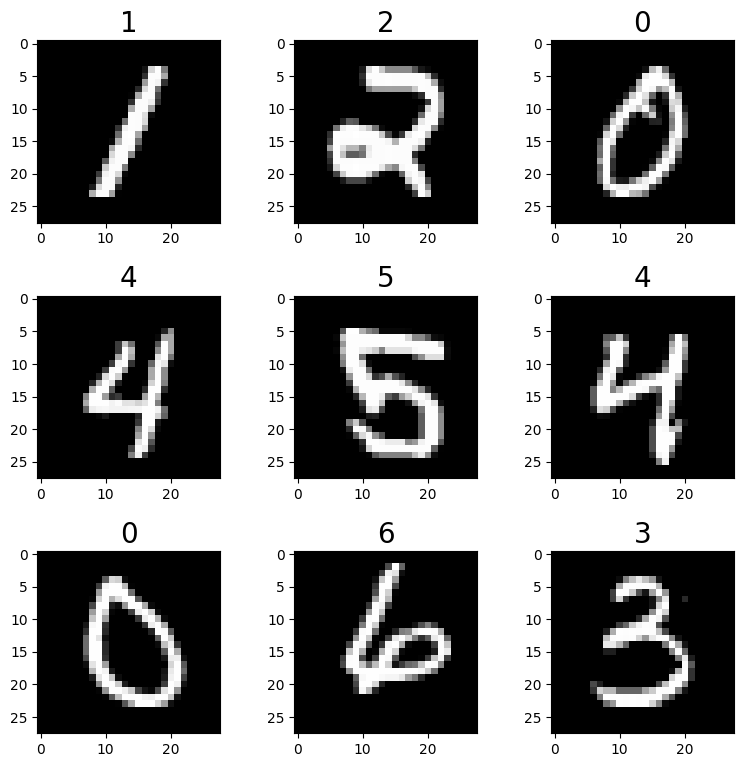

In [7]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(3,3,figsize=(9,9))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(3):
    for j in range(3):
        num = np.random.randint(0,train_label.shape[0])
        ax[i][j].imshow(MNIST_dataset[num][0].reshape((28,28)),cmap="gray")
        ax[i][j].set_title(MNIST_dataset[num][1],fontdict={"fontsize":20})
plt.show()

## 3. Result save path

In [7]:
time_now = time.strftime('%Y-%m-%d-%H_%M_%S', time.localtime(time.time()))
log_path = f'./log/{time_now}'
os.makedirs(log_path)
os.makedirs(f'{log_path}/image')
os.makedirs(f'{log_path}/image/image_all')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

using device: cuda


## 4. Model define

In [2]:
import torch
from torch import nn 

class Discriminator(nn.Module):
    def __init__(self,input_size,inplace=True):
        super(Discriminator,self).__init__()
        c,h,w = input_size
        self.dis = nn.Sequential(
            nn.Linear(c*h*w,512),  # 输入特征数为784，输出为512
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),  # 进行非线性映射
            
            nn.Linear(512, 256),  # 进行一个线性映射
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1),
            nn.Sigmoid()  # 也是一个激活函数，二分类问题中，
            # sigmoid可以班实数映射到【0,1】，作为概率值，
            # 多分类用softmax函数
        )
        
        
    def forward(self,x):
        b,c,h,w = x.size()
        x = x.view(b,-1)
        x = self.dis(x)
        x = x.view(-1)
        return x 

class Generator(nn.Module):
    def __init__(self,in_channel):
        super(Generator,self).__init__() # 调用父类的构造方法
        self.gen = nn.Sequential(
            nn.Linear(in_channel, 128),
            nn.LeakyReLU(0.2),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self,x):
        res = self.gen(x)
        return res.view(x.size()[0],1,28,28)

D = Discriminator(input_size=input_size)
G = Generator(in_channel=in_channel)
D.to(device)
G.to(device)
D,G

NameError: name 'input_size' is not defined

## 6. Training

In [10]:
criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(),lr=0.0003)
G_optimizer = torch.optim.Adam(G.parameters(),lr=0.0003)
D.train()
G.train()
gen_loss_list = []
dis_loss_list = []

for epoch in range(Epoch):
    with tqdm(total=MNIST_dataloader.__len__(),desc=f'Epoch {epoch+1}/{Epoch}')as pbar:
        gen_loss_avg = []
        dis_loss_avg = []
        index = 0
        for batch_idx,(img,_) in enumerate(MNIST_dataloader):
            img = img.to(device)
            # the output label
            valid = torch.ones(img.size()[0]).to(device)
            fake = torch.zeros(img.size()[0]).to(device)
            # Generator input
            G_img = torch.randn([img.size()[0],in_channel],requires_grad=True).to(device)
            # ------------------Update Discriminator------------------
            # forward
            G_pred_gen = G(G_img)
            G_pred_dis = D(G_pred_gen.detach())
            R_pred_dis = D(img)
            # the misfit
            G_loss = criterion(G_pred_dis,fake)
            R_loss = criterion(R_pred_dis,valid)
            dis_loss = (G_loss+R_loss)/2
            dis_loss_avg.append(dis_loss.item())
            # backward
            D_optimizer.zero_grad()
            dis_loss.backward()
            D_optimizer.step()
            # ------------------Update Optimizer------------------
            # forward
            G_pred_gen = G(G_img)
            G_pred_dis = D(G_pred_gen)
            # the misfit
            gen_loss = criterion(G_pred_dis,valid)
            gen_loss_avg.append(gen_loss.item())
            # backward
            G_optimizer.zero_grad()
            gen_loss.backward()
            G_optimizer.step()
            # save figure
            if index % 200 == 0 or index + 1 == MNIST_dataset.__len__():
                save_image(G_pred_gen, f'{log_path}/image/image_all/epoch-{epoch}-index-{index}.png')
            index += 1
            # ------------------进度条更新------------------
            pbar.set_postfix(**{
                'gen-loss': sum(gen_loss_avg) / len(gen_loss_avg),
                'dis-loss': sum(dis_loss_avg) / len(dis_loss_avg)
            })
            pbar.update(1)
        save_image(G_pred_gen, f'{log_path}/image/epoch-{epoch}.png')
    filename = 'epoch%d-genLoss%.2f-disLoss%.2f' % (epoch, sum(gen_loss_avg) / len(gen_loss_avg), sum(dis_loss_avg) / len(dis_loss_avg))
    torch.save(G.state_dict(), f'{log_path}/{filename}-gen.pth')
    torch.save(D.state_dict(), f'{log_path}/{filename}-dis.pth')
    # 记录损失
    gen_loss_list.append(sum(gen_loss_avg) / len(gen_loss_avg))
    dis_loss_list.append(sum(dis_loss_avg) / len(dis_loss_avg))
    # 绘制损失图像并保存
    plt.figure(0)
    plt.plot(range(epoch + 1), gen_loss_list, 'r--', label='gen loss')
    plt.plot(range(epoch + 1), dis_loss_list, 'r--', label='dis loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(f'{log_path}/loss.png', dpi=300)
    plt.close(0)

Epoch 28/1000:   1%|▏         | 6/469 [00:00<00:12, 38.20it/s, dis-loss=0.184, gen-loss=3.04]


KeyboardInterrupt: 

## 7. predict

In [8]:
input_size = [3, 32, 32]
in_channel = 128
gen_para_path = './log/2023-02-22-13_28_08/epoch540-genLoss1.96-disLoss0.35-gen.pth'
dis_para_path = './log/2023-02-22-13_28_08/epoch540-genLoss1.96-disLoss0.35-dis.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator_Transpose(in_channel=in_channel).to(device)
dis = DiscriminatorLinear(input_size=input_size).to(device)
gen.load_state_dict(torch.load(gen_para_path, map_location=device))
gen.eval()
# 随机生成一组数据
G_img = torch.randn([1, in_channel, 1, 1], requires_grad=False).to(device)
# 放入网路
G_pred = gen(G_img)
G_dis = dis(G_pred)
print('generator-dis:', G_dis)
# 图像显示
G_pred = G_pred[0, ...]
G_pred = G_pred.detach().cpu().numpy()
# img,ax = plt.subplots(3,3,figsize=(9,9))
# plt.subplots_adjust(hspace=0.4,wspace=0.4)
# for i in range(3):
#     for j in range(3):
#         num = np.random.randint(0,train_label.shape[0])
#         ax[i][j].imshow(G[num][0].reshape((28,28)),cmap="gray")
#         ax[i][j].set_title(MNIST_dataset[num][1],fontdict={"fontsize":20})
# plt.show()

RuntimeError: Error(s) in loading state_dict for Generator_Transpose:
	Missing key(s) in state_dict: "up1.0.weight", "up1.1.weight", "up1.1.bias", "up1.1.running_mean", "up1.1.running_var", "up2.0.weight", "up2.1.weight", "up2.1.bias", "up2.1.running_mean", "up2.1.running_var", "up3.0.weight", "up3.1.weight", "up3.1.bias", "up3.1.running_mean", "up3.1.running_var", "up4.0.weight", "up4.1.weight", "up4.1.bias", "up4.1.running_mean", "up4.1.running_var", "out_layer.0.weight", "out_layer.1.weight", "out_layer.1.bias", "out_layer.1.running_mean", "out_layer.1.running_var". 
	Unexpected key(s) in state_dict: "gen.0.weight", "gen.0.bias", "gen.2.weight", "gen.2.bias", "gen.3.weight", "gen.3.bias", "gen.3.running_mean", "gen.3.running_var", "gen.3.num_batches_tracked", "gen.5.weight", "gen.5.bias", "gen.6.weight", "gen.6.bias", "gen.6.running_mean", "gen.6.running_var", "gen.6.num_batches_tracked", "gen.8.weight", "gen.8.bias", "gen.9.weight", "gen.9.bias", "gen.9.running_mean", "gen.9.running_var", "gen.9.num_batches_tracked", "gen.11.weight", "gen.11.bias". 